In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.linear_model import LinearRegression
from datetime import datetime

def get_temporal_weights(n_points):
    weights = np.zeros(n_points)
    for i in range(n_points):
        weights[i] = (1.0/(i+1))

    weights = weights/np.sum(weights)
    
    return weights

In [2]:
areas = ['Amran', 'Al Mahwit', "Al Dhale'e", 'Hajjah', "Sana'a", 'Dhamar', 'Abyan', 'Al Hudaydah', 'Al Bayda', 'Amanat Al Asimah', 'Al Jawf', 'Raymah', 'Lahj', 'Aden', 'Ibb', 'Taizz', 'Marib', "Sa'ada", 'Al Maharah', 'Shabwah', 'Moklla', "Say'on"]
df = pd.read_csv('Outbreak.csv',sep=',')

#removing comma which separates thousands
for j in range(len(df)):
    df.set_value(j,'Cases',np.float(df['Cases'][j].replace(',','')))
    
yemen_regions = pd.read_csv('Yemen_original.csv',sep=',')
    
print("Number of areas: "+str(len(areas)))
df.head()

Number of areas: 22


,Date,Governorate,Cases,Deaths,CFR (%),Attack Rate (per 1000),COD Gov English,COD Gov Arabic,COD Gov Pcode
0,2018-01-14,Amran,102231,175,0.17,88.088,Amran,عمران,29.0
1,2018-01-14,Al Mahwit,61097,149,0.24,83.671,Al Mahwit,المحويت,27.0
2,2018-01-14,Al Dhale'e,47132,81,0.17,64.432,Al Dhale'e,الضالع,30.0
3,2018-01-14,Hajjah,118468,420,0.35,50.850,Hajjah,حجة,17.0
4,2018-01-14,Sana'a,74103,123,0.17,50.398,Sana'a,صنعاء,23.0


In [3]:
yemen_regions.head()

,region,Latitude,longitude,population/million,area/km^2
0,Amran,16.15,43.92,1123651,9587
1,Al Mahwit,15.38,43.57,732360,2858
2,Al Dhale'e,13.83,44.74,602613,4786
3,Hajjah,16.09,43.25,1887213,10141
4,Sana'a,15.35,44.32,2279665,15052


In [4]:
# extracting features
recent_cases = np.empty(len(areas),dtype=np.int)
historic_cases = np.empty(len(areas),dtype=np.float64)
death_rate_weighted = np.empty(len(areas),dtype=np.float64)
population_density = np.empty(len(areas),dtype=np.float64)
for i,area in enumerate (areas):
    data = df[df['Governorate']==area]['Cases'].values
    recent_cases[i] = data[0]-data[1]
    
    data = df[df['Governorate']==area]['Cases']
    weights = get_temporal_weights(len(data))
    historic_cases[i] = np.dot(data,weights)
    
    data = df[df['Governorate']==area]['CFR (%)']
    weights = get_temporal_weights(len(data))
    death_rate_weighted[i] = np.dot(data,weights)
    
    population = yemen_regions[yemen_regions['region']==area]['population/million']
    area_size = yemen_regions[yemen_regions['region']==area]['area/km^2']
    population_density[i] = population/area_size
    
#normalisation
normalise = lambda x : x/np.sum(x)
recent_cases = normalise(recent_cases)
historic_cases = normalise(historic_cases)
death_rate_weighted = normalise(death_rate_weighted)
population_density = normalise(population_density)

In [5]:
ratio_past_recent = 0.2
past = (historic_cases + death_rate_weighted + population_density)/3

score = ratio_past_recent*past + (1-ratio_past_recent)*recent_cases
score

array([0.06856677, 0.04811252, 0.00708879, 0.12429693, 0.12060869,
       0.13119036, 0.00398939, 0.10034913, 0.041171  , 0.11693562,
       0.00391202, 0.0765761 , 0.00427984, 0.01322109, 0.06842535,
       0.05518094, 0.00198942, 0.00212306, 0.00116882, 0.00263563,
       0.00744604, 0.00073251])

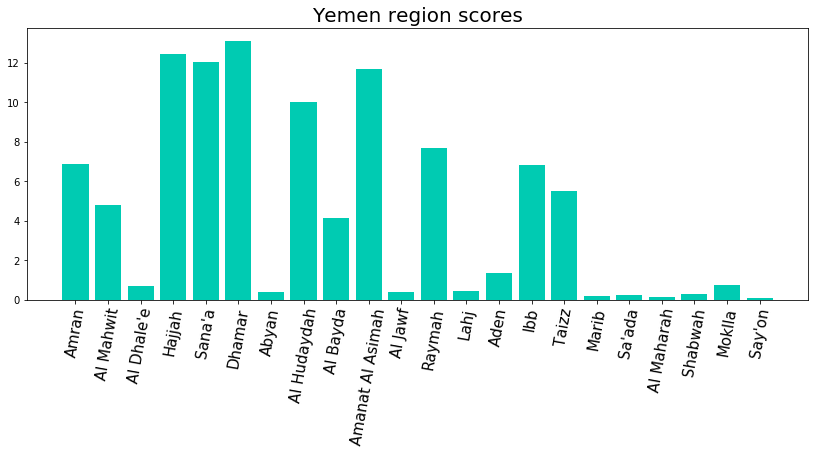

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(14,5)
ax.bar(range(len(areas)),score*100, color='#00cbb2')
ax.set_title('Yemen region scores', size=20)
ax.set_xticks(range(len(areas)))
ax.set_xticklabels(areas, rotation=80, size=15);

In [7]:
# creating feature vectors based on 5 weeks of past data, new cases, death rate, population density
X = np.empty([0,11])
y = []
dates = []
for i,area in enumerate (areas):
    data = df[df['Governorate']==area]['Cases'].values
    new_cases = data-(np.concatenate( [data[1:],[0]]))
    cfr = df[df['Governorate']==area]['CFR (%)'].values

    for j in range(len(new_cases)-5):
        y.append(new_cases[j])
        new_feature_vec = np.zeros([1,11])
        new_feature_vec[0,0:5] = new_cases[j+1:j+6]
        new_feature_vec[0,5:10] = cfr[j+1:j+6]
        new_feature_vec[0,10] = population_density[i]
        X = np.concatenate([X,new_feature_vec])

    dates.append(df[df['Governorate']==area]['Date'].values[:-5])
y = np.array(y)
dates = [e for sub in dates for e in sub]
dates = [datetime.strptime(e, '%Y-%m-%d') for e in dates]


In [8]:
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
y_pred = model.predict(X)

In [10]:
# mean absolute error - linear regression
err_lr = np.sum(np.abs(y-y_pred))/len(y)
err_lr

204.74120099255168

In [11]:
# mean absolute error - predicting average of dataset
err_avg = np.sum(np.abs(y-np.mean(y)))/len(y)
err_avg

322.17171879533953

In [12]:
# error reduction %
(err_avg-err_lr)/err_avg * 100

36.44966673110929

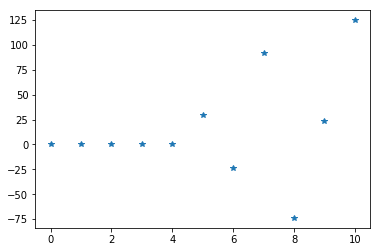

In [13]:
# regression coeficients - new cases do not have any influence?? 
plt.plot(model.coef_, '*')

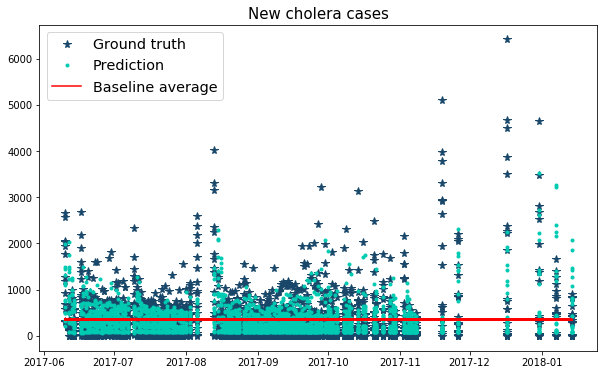

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
plt.plot(dates,y,'*',  markersize=8, color='#184769', label="Ground truth")
plt.plot(dates,y_pred,'.',color='#00cbb2', label="Prediction") 
plt.plot(dates,np.mean(y)*np.ones(len(y)),color='r', label="Baseline average") 
plt.title("New cholera cases", size=15)
plt.legend(fontsize='x-large');